# Salary & Experience Distribution Analysis (Histograms) — Python + SQLite

This notebook demonstrates an end-to-end **Data Analyst workflow**:

1. Load survey data from a **SQLite** database  
2. Use **SQL** to retrieve the analysis dataset  
3. Clean key fields (`CompTotal`, `YearsCodePro`)  
4. Visualize distributions using **histograms**  
5. Summarize **insights** (what the charts mean)

> Dataset: Stack Overflow Developer Survey (SQLite export used in IBM Data Analyst labs).

## 1) Data source (SQLite) & setup

In [21]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

DB_PATH = "survey-data.sqlite"
DB_URL  = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite"

# If the DB doesn't exist locally, try to download it (works in Colab/Jupyter with internet).
if not os.path.exists(DB_PATH):
    try:
        print("Downloading SQLite database...")
        urlretrieve(DB_URL, DB_PATH)
        print(f"Downloaded to: {DB_PATH}")
    except Exception:
        print("Couldn't download the database automatically.")
        print("Please place 'survey-data.sqlite' in the same folder as this notebook, then re-run this cell.")
        raise

conn = sqlite3.connect(DB_PATH)

## 2) Quick database checks (SQL)

In [15]:
pd.read_sql_query("SELECT COUNT(*) AS total_rows FROM main;", conn)

,total_rows
0,65437


In [17]:
pd.read_sql_query("SELECT Age, COUNT(*) as count FROM main GROUP BY Age ORDER BY Age;", conn)

,Age,count
0,18-24 years old,14098
1,25-34 years old,23911
2,35-44 years old,14942
3,45-54 years old,6249
4,55-64 years old,2575
5,65 years or older,772
6,Prefer not to say,322
7,Under 18 years old,2568


In [3]:
pd.read_sql_query("PRAGMA table_info(main);", conn).head(20)

,cid,name,type,notnull,dflt_value,pk
0,0,ResponseId,INTEGER,0,None,0
1,1,MainBranch,TEXT,0,None,0
2,2,Age,TEXT,0,None,0
3,3,Employment,TEXT,0,None,0
4,4,RemoteWork,TEXT,0,None,0
5,5,Check,TEXT,0,None,0
6,6,CodingActivities,TEXT,0,None,0
7,7,EdLevel,TEXT,0,None,0
8,8,LearnCode,TEXT,0,None,0
9,9,LearnCodeOnline,TEXT,0,None,0


## 3) Load analysis dataset

In [24]:
# Load only the columns needed for this analysis (faster + cleaner)
QUERY = '''
SELECT
  CompTotal,
  YearsCodePro, DatabaseWantToWorkWith, RemoteWork
FROM main
WHERE CompTotal IS NOT NULL OR YearsCodePro IS NOT NULL;
'''
df = pd.read_sql_query(QUERY, conn)

df.head()

,CompTotal,YearsCodePro,DatabaseWantToWorkWith,RemoteWork
0,NaN,17,PostgreSQL,Remote
1,NaN,27,Firebase Realtime Database,Remote
2,NaN,7,None,Remote
3,NaN,11,MongoDB;MySQL;PostgreSQL;Redis,Remote
4,NaN,25,Microsoft SQL Server;PostgreSQL;SQLite,In-person


In [5]:
df.shape

(51733, 2)

## 4) Data cleaning (CompTotal & YearsCodePro)

In [6]:
# Convert to numeric; non-numeric values become NaN
df["CompTotal"] = pd.to_numeric(df["CompTotal"], errors="coerce")
df["YearsCodePro"] = pd.to_numeric(df["YearsCodePro"], errors="coerce")

# Basic data-quality snapshot
pd.DataFrame({
    "column": ["CompTotal", "YearsCodePro"],
    "non_null": [df["CompTotal"].notna().sum(), df["YearsCodePro"].notna().sum()],
    "nulls": [df["CompTotal"].isna().sum(), df["YearsCodePro"].isna().sum()],
})

,column,non_null,nulls
0,CompTotal,33740,17993
1,YearsCodePro,48704,3029


In [7]:
df[["CompTotal", "YearsCodePro"]].describe()

,CompTotal,YearsCodePro
count,3.374000e+04,48704.000000
mean,2.963841e+145,10.739652
std,5.444117e+147,8.935175
min,0.000000e+00,1.000000
25%,6.000000e+04,4.000000
50%,1.100000e+05,8.000000
75%,2.500000e+05,15.000000
max,1.000000e+150,50.000000


## 5) Histogram — Total Compensation (CompTotal)

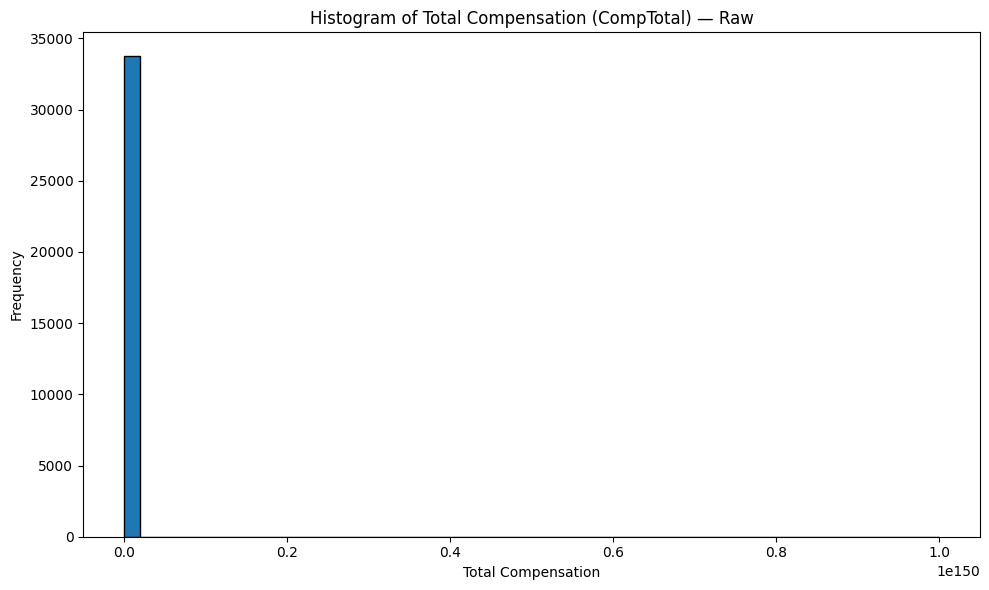

In [8]:
comp = df["CompTotal"].dropna()

plt.figure(figsize=(10,6))
plt.hist(comp, bins=50, edgecolor="black")
plt.title("Histogram of Total Compensation (CompTotal) — Raw")
plt.xlabel("Total Compensation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Insight
Compensation is typically **right-skewed**: most respondents cluster at lower-to-mid values, with a smaller number of very high earners creating a long tail.

Because extreme outliers can hide the main pattern, we also view a **clipped** version (up to the 99th percentile).

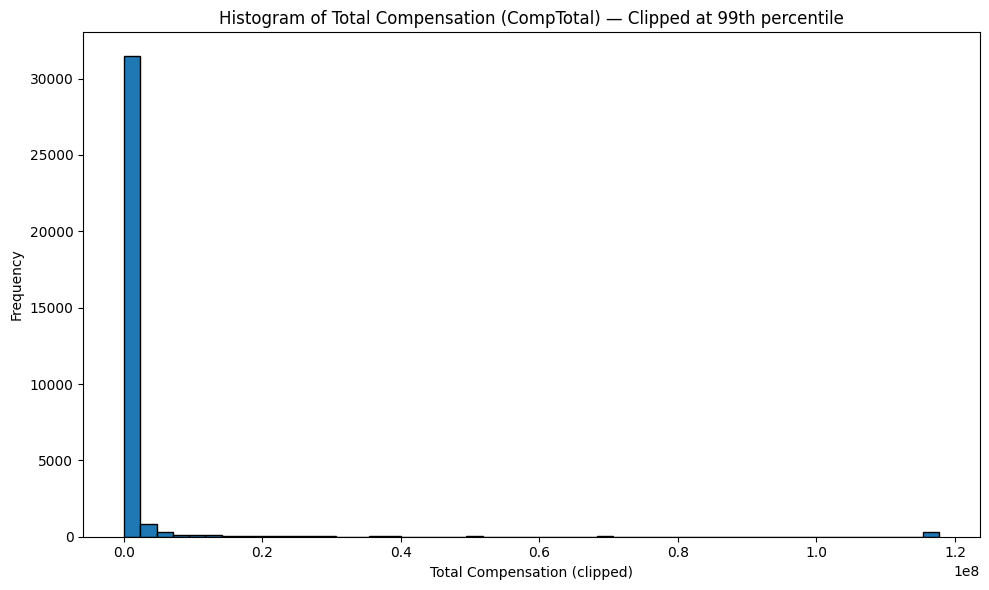

np.float64(117728100.00000012)

In [9]:
# Clip extreme outliers at the 99th percentile to make the central distribution readable
p99 = comp.quantile(0.99)
comp_clipped = comp.clip(upper=p99)

plt.figure(figsize=(10,6))
plt.hist(comp_clipped, bins=50, edgecolor="black")
plt.title("Histogram of Total Compensation (CompTotal) — Clipped at 99th percentile")
plt.xlabel("Total Compensation (clipped)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

p99

> Optional (recommended): a log-scale view often reveals structure in skewed salary data.

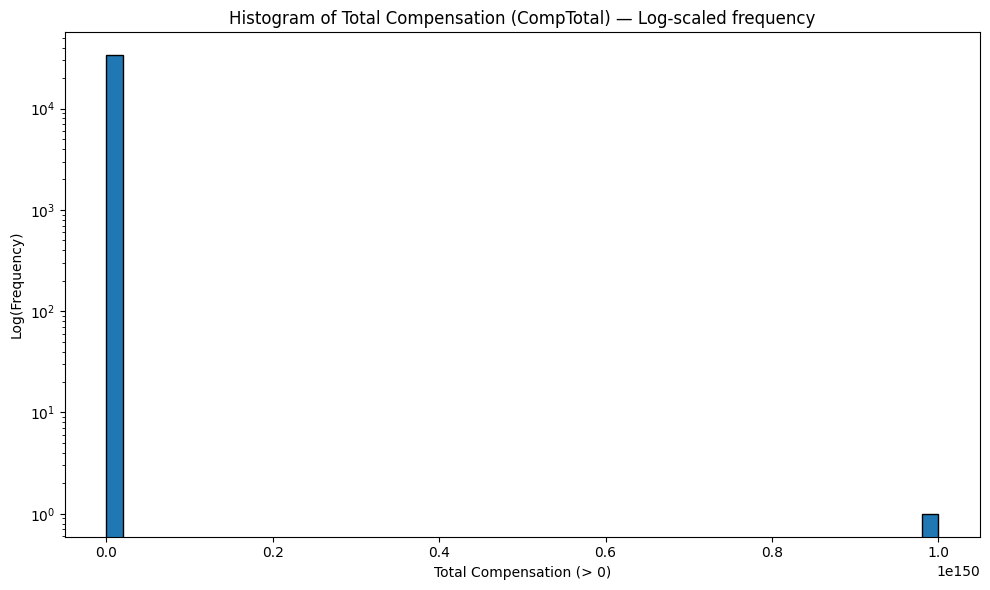

In [10]:
# Log-scale view (drop non-positive values if present)
comp_pos = comp[comp > 0]

plt.figure(figsize=(10,6))
plt.hist(comp_pos, bins=50, edgecolor="black", log=True)
plt.title("Histogram of Total Compensation (CompTotal) — Log-scaled frequency")
plt.xlabel("Total Compensation (> 0)")
plt.ylabel("Log(Frequency)")
plt.tight_layout()
plt.show()

## 6) Histogram — Years of Professional Coding (YearsCodePro)

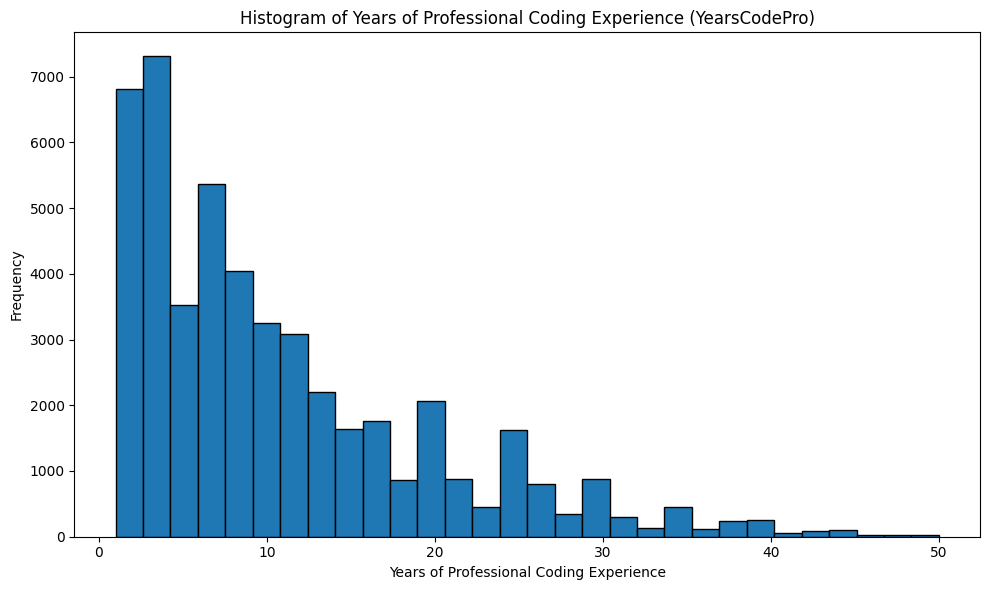

In [19]:
years = df["YearsCodePro"].dropna()

plt.figure(figsize=(10,6))
plt.hist(years, bins=30, edgecolor="black")
plt.title("Histogram of Years of Professional Coding Experience (YearsCodePro)")
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Insight
The distribution often concentrates in early-to-mid career ranges (e.g., a few to ~10 years), with fewer respondents at very high experience levels.

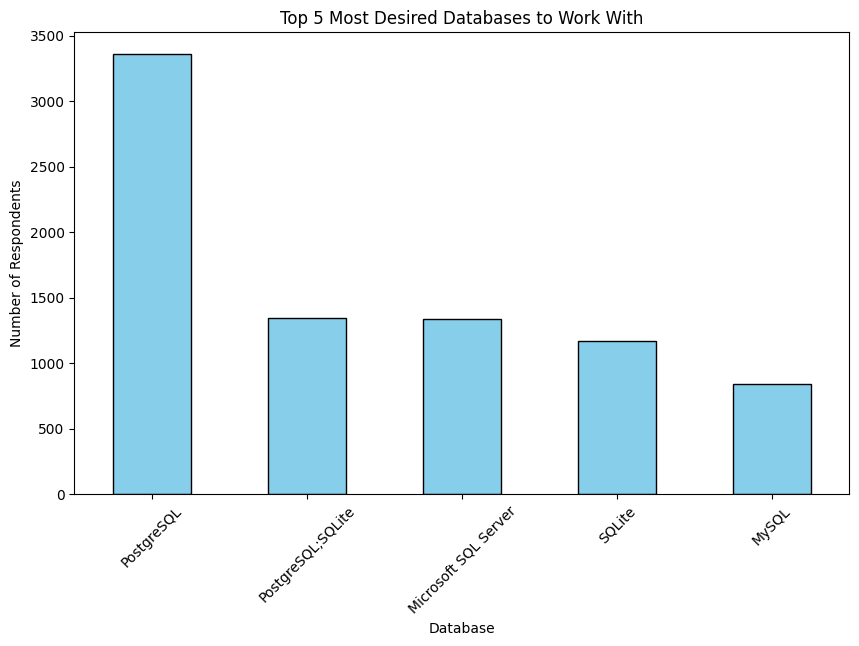

In [26]:

# 1️⃣ تنظيف العمود: إزالة المسافات الزائدة
df['DatabaseWantToWorkWith'] = df['DatabaseWantToWorkWith'].str.strip()

# 2️⃣ حساب تكرارات كل قاعدة بيانات
top_databases = df['DatabaseWantToWorkWith'].value_counts().head(5)

# 3️⃣ رسم Histogram (bar chart)
plt.figure(figsize=(10,6))
top_databases.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 5 Most Desired Databases to Work With')
plt.xlabel('Database')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.show()

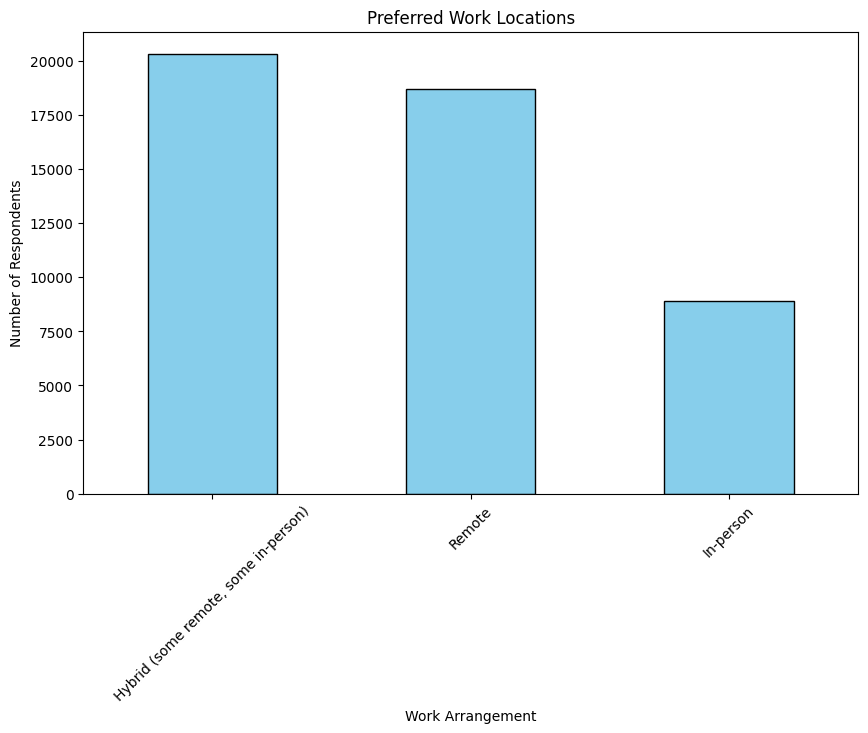

In [27]:

# 1️⃣ تنظيف العمود: إزالة أي مسافات زائدة
df['RemoteWork'] = df['RemoteWork'].str.strip()

# 2️⃣ حساب تكرار كل خيار
remote_counts = df['RemoteWork'].value_counts()

# 3️⃣ رسم histogram (bar chart)
plt.figure(figsize=(10,6))
remote_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Preferred Work Locations')
plt.xlabel('Work Arrangement')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.show()

## 7) Close database connection

In [28]:
conn.close()